# Server side Jax



In [31]:
from syft import jax, jnp
import syft as sy

## The basics

In [32]:
x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [33]:
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [34]:
type(x)

syft.service.action.jax.DeviceArrayObject

## Time difference

In [35]:
import jax as real_jax
long_vector = real_jax.numpy.arange(int(1e7))

%timeit real_jax.numpy.dot(long_vector, long_vector).block_until_ready()

4.88 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

5.47 ms ± 49.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## JAX first transformation: grad

In [37]:
def sum_of_squares(x):
  return jnp.sum(x**2)


In [38]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


In [39]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.2 -0.2 -0.2 -0.2]


In [40]:
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)  # Find gradient wrt both x & y


(DeviceArray([-0.2, -0.2, -0.2, -0.2], dtype=float64),
 DeviceArray([0.2, 0.2, 0.2, 0.2], dtype=float64))

In [41]:
jax.value_and_grad(sum_squared_error)(x, y)


(DeviceArray(0.04, dtype=float64),
 DeviceArray([-0.2, -0.2, -0.2, -0.2], dtype=float64))

## Error Propagation

In [43]:
def squared_error_with_aux(x, y):
  return sum_squared_error(x, y), x-y

jax.grad(squared_error_with_aux)(x, y)

TypeError: Gradient only defined for scalar-output functions. Output was (DeviceArray(0.04, dtype=float64), DeviceArray([-0.1, -0.1, -0.1, -0.1], dtype=float64)).

In [44]:
jax.grad(squared_error_with_aux, has_aux=True)(x, y)[0]

DeviceArray([-0.2, -0.2, -0.2, -0.2], dtype=float64)

In [45]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
  x[0] = 123
  return None

in_place_modify(x)
x

array([123,   2,   3])

In [46]:
in_place_modify(jnp.array(x))  # Raises error when we cast input to jnp.ndarray


TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
def jax_in_place_modify(x):
  return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)


## Basic Model Training

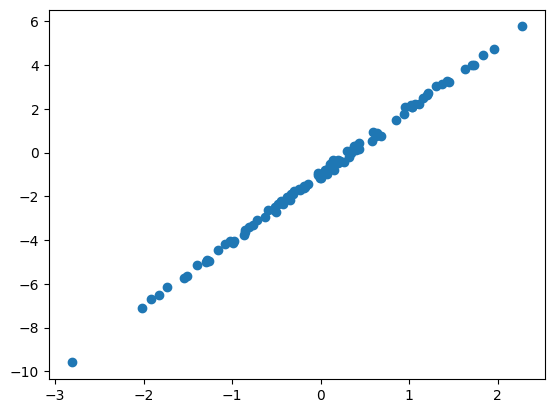

In [47]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

In [48]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.00, b: -1.01


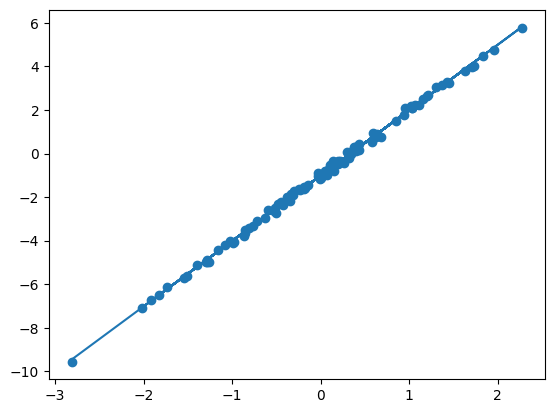

In [49]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, np.asanyarray(model(theta, xs)))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")